# ChaosBench

ChaosBench is a benchmark project to improve and extend the predictability range of deep weather emulators to the subseasonal-to-seasonal (S2S) range. Predictability at this scale is more challenging due to its: (1) double sensitivities to intial condition (in weather-scale) and boundary condition (in climate-scale), (2) butterfly effect, and our (3) inherent lack of understanding of physical processes operating at this scale. Thus, given the high socioeconomic stakes for accurate, reliable, and stable S2S forecasts (e.g., for disaster/extremes preparedness), this benchmark is timely for DL-accelerated solutions.

> __NOTE__ More information can be found at: https://leap-stc.github.io/ChaosBench

Let's begin by understanding the core dataset and how to load them! 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from chaosbench import dataset, utils

1. First, we can load the dataset by specifying the time (years).

> __NOTE__ Dataset are available between 1979-2023 with daily temporal resolution.
>
> __BUT__ for this event, we only made available the years 2022-2023. __DO NOT__ use the year 2023 for training; i.e., reserved for evaluation.

In [3]:
# Define years
train_years = np.arange(2022, 2023)
print(train_years)


[2022]


In [4]:
# Now passing in the `years` argument allows us to load the dataset for those years.
train_dataset = dataset.S2SObsDataset(years=train_years)


In [5]:
# Let's inspect the dataset
time_idx = 0 # Define the timestep to inspect e.g., first day of the year (1st January)
timestamp, train_x, train_y = train_dataset[time_idx]

print(f'input shape: (n_variables, lat, lon): {train_x.shape}') # input
print(f'output shape: (future_steps, n_variables, lat, lon): {train_y.shape}') # output: by default, 1-day ahead


input shape: (n_variables, lat, lon): torch.Size([60, 121, 240])
output shape: (future_steps, n_variables, lat, lon): torch.Size([1, 60, 121, 240])


> __NOTE__ Take note of the input and output shapes, as these will be used throughout.
>
> $x$ = input
> 
> $y$ = output/target (by default 1 day ahead, i.e., tomorrow)

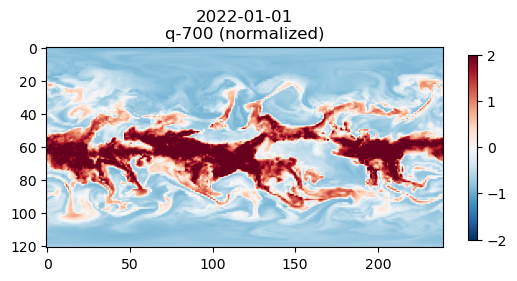

In [6]:
# Let's plot the dataset 
# e.g., humidity, q, at 700-hPa level --> which measures near surface wetness and can be useful to track drought!

time_idx = 0 # Define the timestep to inspect e.g., first day of the validation dataset 
param_name = 'q-700' # Define the variable to be inspected e.g., temperature q at pressure level 700 hPa

## Get the dataset
timestamp, train_x, train_y = train_dataset[time_idx]

## Get the index to subset
param_idx = train_dataset.era5_idx.index(
     utils.get_param_level_idx(*param_name.split('-')) # Get the variable index for plotting
)

## Plot!
plt.imshow(train_x[param_idx], cmap='RdBu_r', vmin=-2, vmax=2)

plt.colorbar(shrink=0.5)
plt.title(f'{utils.convert_time(timestamp)}\n{param_name} (normalized)')
plt.show();


2. Next, we also have the freedom to choose the variables. Try changing the `atmos_vars`, `land_vars`, and/or `ocean_vars` and see what you get.

> __NOTE__ Learn more about the full list of variables here: https://leap-stc.github.io/ChaosBench/dataset.html
>
> The table below describes some examples of the variables.

| Earth System | Variable Acronym  | Long Name                                                        |
|--------------|----------|------------------------------------------------------------------|
| Atmos        | t-850    | Temperature at 850 hPa vertical level                           |
| Atmos        | z-500    | Geopotential height at 500 hPa vertical level                  |
| Atmos        | q-700    | Specific humidity at 700 hPa vertical level                    |
| Atmos        | u-850    | Horizontal windspeed (u-direction) at 850 hPa vertical level   |
| Atmos        | v-850    | Horizontal windspeed (v-direction) at 850 hPa vertical level   |
| Land         | tp       | Total precipitation                                             |
| Ocean        | sosstsst | Sea surface temperature   

In [7]:
# Specify variables to be used
## More details on the variables can be found at https://leap-stc.github.io/ChaosBench/dataset.html
## We have atmos_vars, ocean_vars (optional), land_vars (optional)
TARGET_VARS = ['t-850', 'z-500', 'q-700'] # MANDATORY for evaluation

## Additional variables for feature engineering
atmos_vars = ['u-850', 'v-850'] ## Let's try adding wind speed 
land_vars = ['tp'] ## And some precipitation
ocean_vars = ['sosstsst'] ## And maybe some sea surface temperature


In [8]:
# Same as before, we build the dataset object
train_dataset = dataset.S2SObsDataset(
    years = train_years, # Years for training
    atmos_vars = TARGET_VARS + atmos_vars, # Atmospheric variables; if not given will use ALL 60 variables
    land_vars = land_vars, # Land variables
    ocean_vars = ocean_vars # Ocean variables
)


Let's inspect the dataset!

In [9]:
# Notice n_variables == 7: target_vars + atmos + land + ocean variables
time_idx = 0 # Define the timestep to inspect e.g., first day of the year (1st January)
timestamp, train_x, train_y = train_dataset[time_idx]

print(f'input shape: (n_variables, lat, lon): {train_x.shape}')
print(f'input shape: (future_steps, n_variables, lat, lon): {train_y.shape}')


input shape: (n_variables, lat, lon): torch.Size([7, 121, 240])
input shape: (future_steps, n_variables, lat, lon): torch.Size([1, 7, 121, 240])


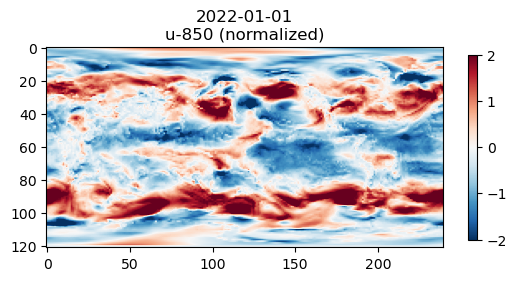

In [10]:
# Let's plot the dataset 
# e.g., u @ 850-hPa level --> measures near surface wind speed and can be useful as hurricane proxies!

time_idx = 0 # Define the timestep to inspect e.g., first day of the validation dataset 
param_name = 'u-850' # Define the variable to be inspected e.g., wind speed u at pressure level 850 hPa

## Get the dataset
timestamp, train_x, train_y = train_dataset[time_idx]

## Get the index to subset
param_idx = train_dataset.era5_idx.index(
     utils.get_param_level_idx(*param_name.split('-')) # Get the variable index for plotting
)

## Plot!
plt.imshow(train_x[param_idx], cmap='RdBu_r', vmin=-2, vmax=2)

plt.colorbar(shrink=0.5)
plt.title(f'{utils.convert_time(timestamp)}\n{param_name} (normalized)')
plt.show();


3. Lastly, we do provide greater control over how you subset along the time dimension.

> __NOTE__ Recall that in the previous examples, the default __output (y)__ is a snapshot 1 day ahead in time (i.e., tomorrow).

In [11]:
# Same as before, but we pass a new argument called `lead_time`
lead_time = 44 ## This will give us an output (y) with variables that are 44 days ahead in time

train_dataset = dataset.S2SObsDataset(
    years = train_years,
    lead_time = lead_time, # NEW: Lead time
    atmos_vars = TARGET_VARS + atmos_vars,
    land_vars = land_vars,
    ocean_vars = ocean_vars
)


In [12]:
# Lets see the data structure
time_idx = 0
timestamp, train_x, train_y = train_dataset[time_idx]

print(train_x.shape) # (n_variables, lat, lon)
print(train_y.shape) # (timestep, n_variables, lat, lon)


torch.Size([7, 121, 240])
torch.Size([1, 7, 121, 240])


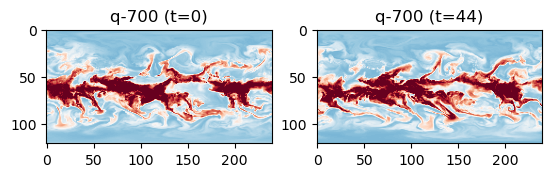

In [13]:
## Plot input-output pair!
param_name = 'q-700'

## Get the index to subset
param_idx = train_dataset.era5_idx.index(
     utils.get_param_level_idx(*param_name.split('-')) # Get the variable index for plotting
)

f, ax = plt.subplots(1,2)
ax[0].imshow(train_x[param_idx], cmap='RdBu_r', vmin=-2, vmax=2)
ax[0].set_title(f'{param_name} (t={0})')

ax[1].imshow(train_y[0,param_idx], cmap='RdBu_r', vmin=-2, vmax=2)
ax[1].set_title(f'{param_name} (t={lead_time})')

plt.show();


You can also construct an input-output pair at `time=0` to target a __timeseries__ with length `time=44`. Notice the additional argument `n_step` below.

In [14]:
# Same as before, but we pass a new argument called lead_time
n_step = 44

train_dataset = dataset.S2SObsDataset(
    years = train_years,
    n_step = n_step, # NEW: Number of step
    atmos_vars = TARGET_VARS + atmos_vars,
    land_vars = land_vars,
    ocean_vars = ocean_vars
)


In [15]:
# Lets see the data structure (Notice: timestep is 44 now in train_y)
time_idx = 0
timestamp, train_x, train_y = train_dataset[time_idx]

print(train_x.shape) # (n_variables, lat, lon)
print(train_y.shape) # (timestep, n_variables, lat, lon)


torch.Size([7, 121, 240])
torch.Size([44, 7, 121, 240])


> __NOTE__ Since we are loading a __timeseries__ as our output (y), the processing time will take a while. So use this with caution!

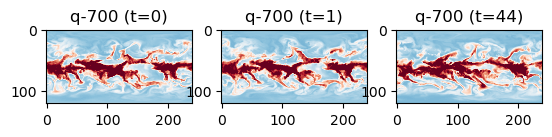

In [16]:
## Plot input-output pair!
param_name = 'q-700'

## Get the index to subset
param_idx = train_dataset.era5_idx.index(
     utils.get_param_level_idx(*param_name.split('-')) # Get the variable index for plotting
)

f, ax = plt.subplots(1,3)
ax[0].imshow(train_x[param_idx], cmap='RdBu_r', vmin=-2, vmax=2)
ax[0].set_title(f'{param_name} (t={0})')

ax[1].imshow(train_y[0,param_idx], cmap='RdBu_r', vmin=-2, vmax=2)
ax[1].set_title(f'{param_name} (t={1})')

ax[2].imshow(train_y[-1,param_idx], cmap='RdBu_r', vmin=-2, vmax=2)
ax[2].set_title(f'{param_name} (t={n_step})')

plt.show();
